In [1]:
import os
import pandas as pd
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy import ndimage
from collections import Counter
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 固定 Python 的随机种子
random.seed(42)

# 固定 PyTorch 的随机种子
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(42)

In [3]:
# 模型保存路径
GTSRBNet_save_path = 'models/GTSRBNet.pth'
LeNet_save_path = 'models/LeNet.pth'

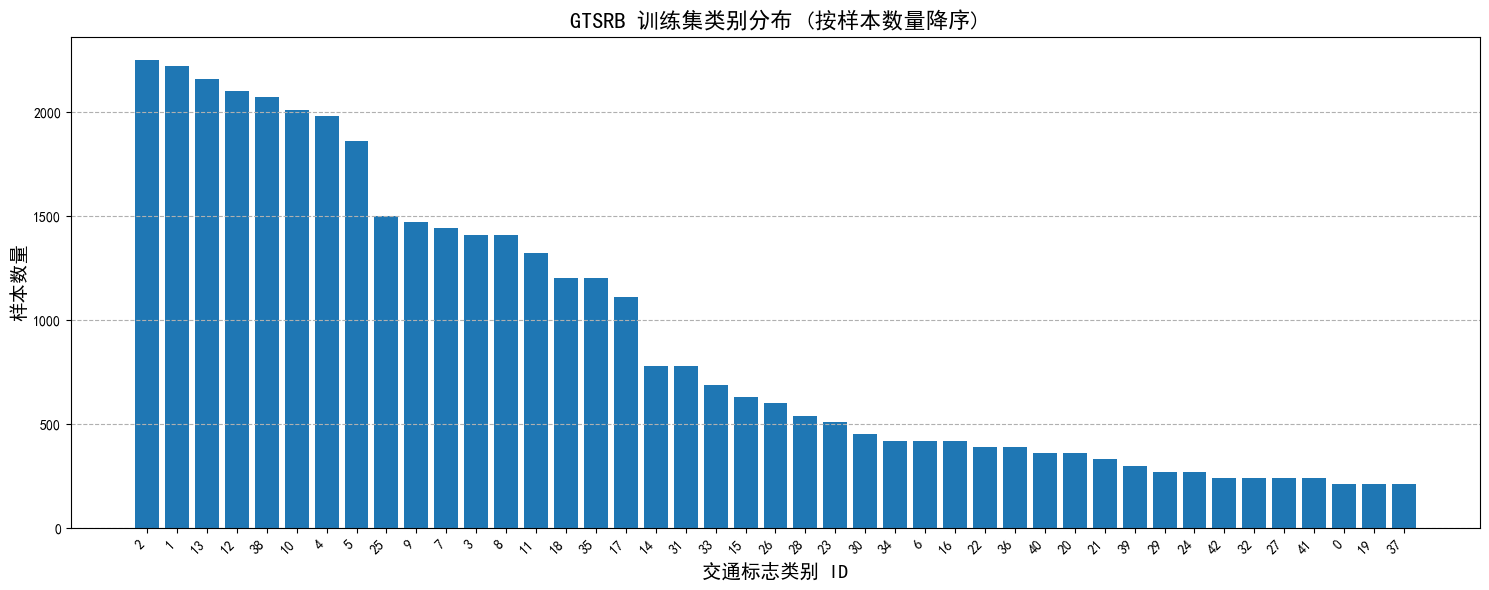

In [4]:
# 数据集路径
train_dir = 'data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images'
test_dir = 'data/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images'

# 加载训练数据
train_images = []
train_labels = []

for class_id in range(43):
    class_path = os.path.join(train_dir, f'{class_id:05d}')
    csv_file = os.path.join(class_path, f'GT-{class_id:05d}.csv')

    if os.path.exists(csv_file):
        df = pd.read_csv(csv_file, sep=';')
        for _, row in df.iterrows():
            img_path = os.path.join(class_path, row['Filename'])
            if os.path.exists(img_path):
                train_images.append(img_path)
                train_labels.append(int(row['ClassId']))

# 按样本数量降序排序
label_counts_sorted = pd.Series(train_labels).value_counts()

plt.figure(figsize=(15, 6))

# 绘制纵向柱状图
# plt.bar(label_counts_sorted.index.astype(str), label_counts_sorted.values, color='coral')
plt.bar(label_counts_sorted.index.astype(str), label_counts_sorted.values)

# --- 图表美化 ---
plt.title('GTSRB 训练集类别分布 (按样本数量降序)', fontsize=16)
plt.xlabel('交通标志类别 ID', fontsize=14)
plt.ylabel('样本数量', fontsize=14)
plt.xticks(rotation=45, ha='right') # 旋转X轴标签，防止重叠
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# 1 数据质量检查

## 1.1 图像尺寸与比例检查 & 1.2 图像清晰度检查

正在读取图像尺寸...


100%|██████████| 39209/39209 [00:44<00:00, 889.95it/s] 


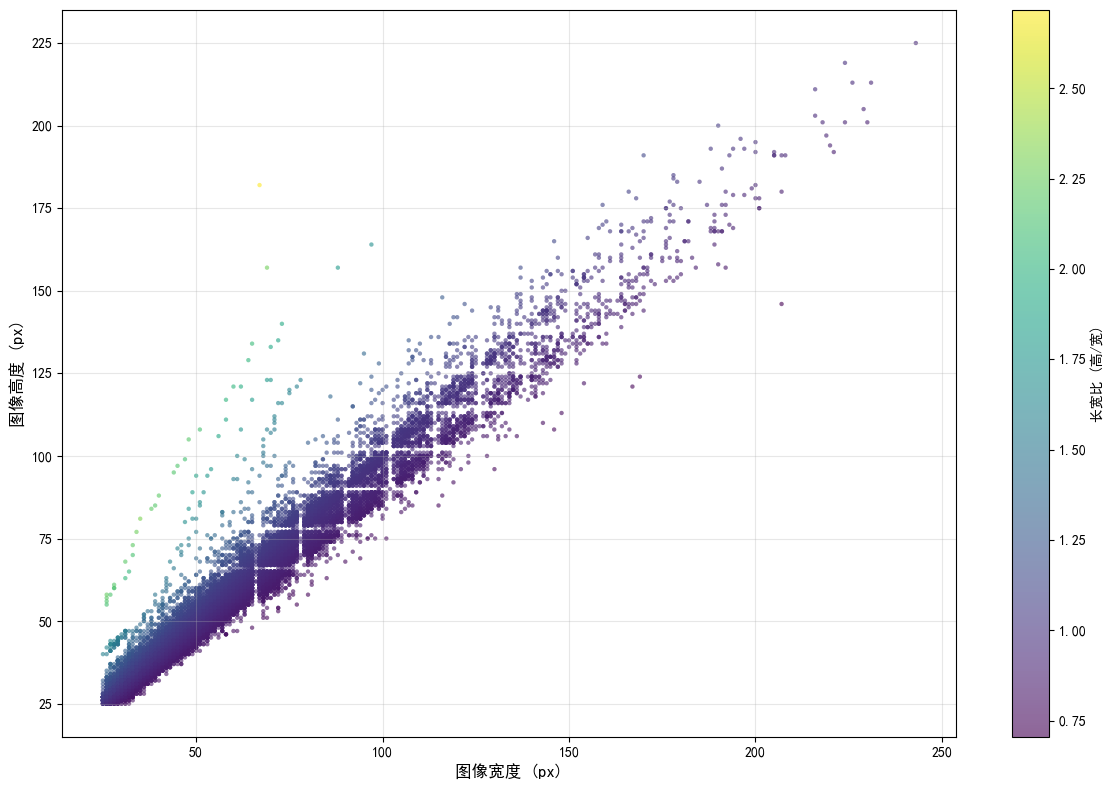


图像尺寸统计:
总图像数: 39209
宽度范围: 25 - 243 px
高度范围: 25 - 225 px
长宽比范围: 0.71 - 2.72
平均长宽比: 1.00

警告: 发现 29 个极端长宽比 (< 0.5 或 > 2.0)


In [5]:
# 拉普拉斯算子方差评估图像清晰度
def variance_of_laplacian(image):
    """
    使用拉普拉斯算子方差评估图像清晰度
    值越大，图像越清晰
    """
    gray = np.array(image.convert('L'))
    laplacian = ndimage.laplace(gray)
    return laplacian.var()

# 收集所有图像的尺寸信息
widths = []
heights = []
aspect_ratios = []

# 收集所有图像的清晰度分数
blur_scores = []

print("正在读取图像尺寸...")
for img_path in tqdm(train_images):
    try:
        img = Image.open(img_path)
        width, height = img.size
        widths.append(width)
        heights.append(height)
        aspect_ratios.append(height / width)  # 长宽比 = 高/宽

        score = variance_of_laplacian(img)
        blur_scores.append(score)
    except Exception as e:
        print(f"读取 {img_path} 时出错: {e}")

# 绘制散点图
plt.figure(figsize=(12, 8))

# 使用散点图，颜色表示长宽比
scatter = plt.scatter(widths, heights, c=aspect_ratios, cmap='viridis', 
                     alpha=0.6, s=10, edgecolors='none')

plt.xlabel('图像宽度 (px)', fontsize=12)
plt.ylabel('图像高度 (px)', fontsize=12)
# plt.title('图像尺寸分布与长宽比', fontsize=14)
plt.colorbar(scatter, label='长宽比 (高/宽)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 输出统计信息
print(f"\n图像尺寸统计:")
print(f"总图像数: {len(widths)}")
print(f"宽度范围: {min(widths)} - {max(widths)} px")
print(f"高度范围: {min(heights)} - {max(heights)} px")
print(f"长宽比范围: {min(aspect_ratios):.2f} - {max(aspect_ratios):.2f}")
print(f"平均长宽比: {sum(aspect_ratios)/len(aspect_ratios):.2f}")

# 检查是否有极端长宽比
extreme_ratios = [ratio for ratio in aspect_ratios if ratio < 0.5 or ratio > 2.0]
if extreme_ratios:
    print(f"\n警告: 发现 {len(extreme_ratios)} 个极端长宽比 (< 0.5 或 > 2.0)")
else:
    print(f"\n未发现极端长宽比")

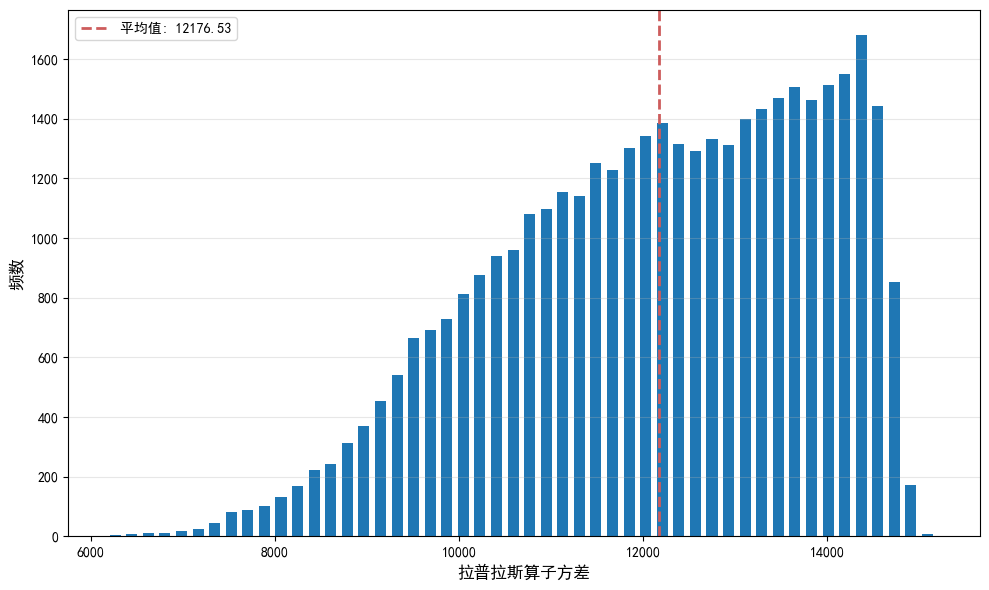


清晰度统计:
平均清晰度: 12176.53
最清晰样本的分数: 15210.01
最模糊样本的分数: 6205.20
中位数: 12347.10

模糊图片检查 (阈值 < 100):
模糊图片数量: 0
模糊图片比例: 0.00%


In [6]:
# 绘制清晰度分布图
plt.figure(figsize=(10, 6))
# plt.hist(blur_scores, bins=50, color='#008BFB', alpha=0.7, edgecolor='black')
plt.hist(blur_scores, bins=50, width=120)
plt.xlabel('拉普拉斯算子方差', fontsize=12)
plt.ylabel('频数', fontsize=12)
# plt.title('图像清晰度分布', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.axvline(x=np.mean(blur_scores), color='indianred', linestyle='--', 
            linewidth=2, label=f'平均值: {np.mean(blur_scores):.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# 输出统计信息
print(f"\n清晰度统计:")
print(f"平均清晰度: {np.mean(blur_scores):.2f}")
print(f"最清晰样本的分数: {np.max(blur_scores):.2f}")
print(f"最模糊样本的分数: {np.min(blur_scores):.2f}")
print(f"中位数: {np.median(blur_scores):.2f}")

# 判断模糊阈值（经验上 <100 算较模糊）
blur_threshold = 100
blurred = [s for s in blur_scores if s < blur_threshold]
print(f"\n模糊图片检查 (阈值 < {blur_threshold}):")
print(f"模糊图片数量: {len(blurred)}")
print(f"模糊图片比例: {len(blurred)/len(blur_scores)*100:.2f}%")

# 2 数据预处理

## 2.1 图像尺寸统一 & 2.2 像素值归一化

In [7]:
transform_no_norm = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# 简单的数据集类
class SimpleDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        img = self.transform(img)
        return img, self.labels[idx]
    
# 随机打乱数据（同时打乱图片和标签）
combined = list(zip(train_images, train_labels))
random.seed(42)
random.shuffle(combined)
train_images, train_labels = zip(*combined)

# 划分训练集和验证集 (80% 训练, 20% 验证)
split_idx = int(len(train_images) * 0.8)
train_data_temp = SimpleDataset(list(train_images[:split_idx]), list(train_labels[:split_idx]), transform_no_norm)
train_loader_temp = DataLoader(train_data_temp, batch_size=64, shuffle=False)

# 初始化累加器
channel_sum = torch.zeros(3)  # 用于累加每个通道的像素值
channel_squared_sum = torch.zeros(3)  # 用于累加每个通道的像素值的平方
num_pixels = 0  # 总像素数

for images, _ in tqdm(train_loader_temp):
    # images 的形状为 [batch_size, 3, 32, 32]
    num_pixels += images.size(0) * images.size(2) * images.size(3)  # 累加像素总数
    channel_sum += images.sum(dim=[0, 2, 3])  # 累加每个通道的像素值
    channel_squared_sum += (images ** 2).sum(dim=[0, 2, 3])  # 累加每个通道的像素值的平方

# 计算均值和标准差
mean = channel_sum / num_pixels
std = torch.sqrt(channel_squared_sum / num_pixels - mean ** 2)



# 图像变换
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(tuple(mean), tuple(std))
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(tuple(mean), tuple(std))
])

train_data = SimpleDataset(list(train_images[:split_idx]), list(train_labels[:split_idx]), transform_train)
val_data = SimpleDataset(list(train_images[split_idx:]), list(train_labels[split_idx:]), transform_test)

100%|██████████| 491/491 [00:11<00:00, 41.30it/s]


## 2.3 过采样

In [8]:
# 对少数类进行过采样
label_counts = Counter(train_labels[:split_idx])
n_classes = len(label_counts)

weights = []
for lbl in train_labels[:split_idx]:
    class_count = label_counts.get(lbl, 1)   # 防止漏掉
    weights.append(1.0 / class_count)

weights = torch.DoubleTensor(weights)

sampler = WeightedRandomSampler(
    weights=weights,
    num_samples=len(weights),   # 每个 epoch 采样与原训练集同样大小的样本
    replacement=True            # 允许重复采样（过采样必选）
)

train_loader = DataLoader(train_data, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

print(f'训练集: {len(train_data)}, 验证集: {len(val_data)}')

训练集: 31367, 验证集: 7842


## 2.4 测试集加载器

In [9]:
# 加载测试集 CSV（包含真值标签）
test_csv = os.path.join('data', 'GTSRB_Final_Test_GT', 'GT-final_test.csv')
df_test = pd.read_csv(test_csv, sep=';')

test_images = [os.path.join(test_dir, row['Filename']) for _, row in df_test.iterrows()]
test_data = SimpleDataset(test_images, [-1]*len(test_images), transform_test)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# 3 建模

## 3.1 定义模型 GTSRBNet

In [10]:
# 参考LeNet的CNN模型
class GTSRBNet(nn.Module):
    def __init__(self, num_classes=43, dropout_p=0.5):
        super(GTSRBNet, self).__init__()
        # 第一层：卷积 + 池化
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2, 2)
        # 第二层：卷积 + 池化
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # 全连接层（简化为两层）
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, num_classes)  # 直接到输出
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)  # 展平
        x = self.relu(self.fc1(x))
        x = self.dropout(x)         # 在隐藏层后加 Dropout
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'使用设备: {device}')

使用设备: cuda


## 3.2 参数调优

In [ ]:
def fit_model(learning_rate, dropout_p):
    print(f'\n正在训练: 学习率={learning_rate}, Dropout 率={dropout_p}')
    
    # 定义模型、损失函数和优化器
    model = GTSRBNet(43, dropout_p).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)



    num_epochs = 5
    best_acc = 0

    # 初始化记录列表
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        # 训练
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc='训练中')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # 验证
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        val_pbar = tqdm(val_loader, desc='验证中')
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # 计算平均指标
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        # 保存到列表
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # print(f'\n训练 Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.2f}%')
        # print(f'验证 Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.2f}%')
        
        if val_acc > best_acc:
            best_acc = val_acc

    print(f'\n训练完成! 最佳验证准确率: {best_acc:.2f}%')
    return best_acc

In [12]:
from itertools import product

# 定义超参数网格
param_grid = {
    'learning_rate': [0.0005, 0.001, 0.002],
    'dropout_p': [0.2, 0.3, 0.5],
}

# 获取所有超参数组合
param_combinations = list(product(*param_grid.values()))

# 保存最佳超参数和性能
best_params = None
best_val_acc = 0

# 遍历所有超参数组合
for params in param_combinations:
    learning_rate, dropout_p = params
    best_acc = fit_model(learning_rate, dropout_p)

    # 更新最佳超参数
    if best_acc > best_val_acc:
        best_val_acc = best_acc
        best_params = {'learning_rate': learning_rate, 'dropout_p': dropout_p}

print(f'\n最佳超参数: {best_params}')
print(f'最佳验证准确率: {best_val_acc:.2f}%')


正在训练: 学习率=0.0005, Dropout 率=0.2

Epoch 1/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 40.36it/s]



Epoch 2/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 42.01it/s]



Epoch 3/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 38.49it/s]



Epoch 4/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 40.97it/s]



Epoch 5/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 44.04it/s]



训练完成! 最佳验证准确率: 95.84%

正在训练: 学习率=0.0005, Dropout 率=0.3

Epoch 1/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 38.71it/s]



Epoch 2/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 42.09it/s]



Epoch 3/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 38.62it/s]



Epoch 4/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 36.34it/s]



Epoch 5/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 41.05it/s]



训练完成! 最佳验证准确率: 96.19%

正在训练: 学习率=0.0005, Dropout 率=0.5

Epoch 1/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 41.93it/s]



Epoch 2/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 40.77it/s]



Epoch 3/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 40.88it/s]



Epoch 4/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.42it/s]



Epoch 5/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 40.57it/s]



训练完成! 最佳验证准确率: 95.07%

正在训练: 学习率=0.001, Dropout 率=0.2

Epoch 1/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 42.10it/s]



Epoch 2/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.27it/s]



Epoch 3/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 41.61it/s]



Epoch 4/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 36.16it/s]



Epoch 5/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 41.07it/s]



训练完成! 最佳验证准确率: 97.87%

正在训练: 学习率=0.001, Dropout 率=0.3

Epoch 1/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 36.59it/s]



Epoch 2/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 41.45it/s]



Epoch 3/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 45.14it/s]



Epoch 4/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:09<00:00, 13.53it/s]



Epoch 5/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 43.09it/s]



训练完成! 最佳验证准确率: 97.16%

正在训练: 学习率=0.001, Dropout 率=0.5

Epoch 1/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 41.41it/s]



Epoch 2/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 40.59it/s]



Epoch 3/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 35.35it/s]



Epoch 4/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 40.87it/s]



Epoch 5/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 41.95it/s]



训练完成! 最佳验证准确率: 95.75%

正在训练: 学习率=0.002, Dropout 率=0.2

Epoch 1/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 37.23it/s]



Epoch 2/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.34it/s]



Epoch 3/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 38.21it/s]



Epoch 4/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.25it/s]



Epoch 5/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 40.83it/s]



训练完成! 最佳验证准确率: 97.35%

正在训练: 学习率=0.002, Dropout 率=0.3

Epoch 1/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 43.24it/s]



Epoch 2/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 34.21it/s]



Epoch 3/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 38.28it/s]



Epoch 4/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 37.78it/s]



Epoch 5/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 38.65it/s]



训练完成! 最佳验证准确率: 97.79%

正在训练: 学习率=0.002, Dropout 率=0.5

Epoch 1/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 41.33it/s]



Epoch 2/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 42.38it/s]



Epoch 3/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 40.96it/s]



Epoch 4/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.49it/s]



Epoch 5/5
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 44.10it/s]


训练完成! 最佳验证准确率: 97.84%

最佳超参数: {'learning_rate': 0.001, 'dropout_p': 0.2}
最佳验证准确率: 97.87%


## 3.3 模型训练

In [13]:
best_params = {'learning_rate': 0.001, 'dropout_p': 0.2}

model = GTSRBNet(43, best_params['dropout_p']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

num_epochs = 10
best_acc = 0

# 初始化记录列表
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # 训练
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc='训练中')
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # 更新进度条
        current_acc = 100 * train_correct / train_total
        train_pbar.set_postfix({
            'loss': f'{train_loss/(train_total//labels.size(0)):.4f}',
            'acc': f'{current_acc:.2f}%'
        })
    
    # 验证
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    val_pbar = tqdm(val_loader, desc='验证中')
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # 更新进度条
            current_acc = 100 * val_correct / val_total
            val_pbar.set_postfix({
                'loss': f'{val_loss/(val_total//labels.size(0)):.4f}',
                'acc': f'{current_acc:.2f}%'
            })

    # 计算平均指标
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    # 保存到列表
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'\n训练 Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.2f}%')
    print(f'验证 Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.2f}%')
    
    if val_acc > best_acc:
        best_acc = val_acc
        # torch.save(model.state_dict(), GTSRBNet_save_path)
        print(f'✓ 保存最佳模型 (验证准确率: {val_acc:.2f}%)')

print(f'\n训练完成! 最佳验证准确率: {best_acc:.2f}%')


Epoch 1/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 40.92it/s, loss=0.2114, acc=89.48%]



训练 Loss: 1.3353, Acc: 62.63%
验证 Loss: 0.3954, Acc: 89.48%
✓ 保存最佳模型 (验证准确率: 89.48%)

Epoch 2/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 43.76it/s, loss=0.1228, acc=94.43%]



训练 Loss: 0.3046, Acc: 91.33%
验证 Loss: 0.2296, Acc: 94.43%
✓ 保存最佳模型 (验证准确率: 94.43%)

Epoch 3/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 40.34it/s, loss=0.0817, acc=95.93%]



训练 Loss: 0.1702, Acc: 95.29%
验证 Loss: 0.1528, Acc: 95.93%
✓ 保存最佳模型 (验证准确率: 95.93%)

Epoch 4/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.78it/s, loss=0.0682, acc=96.67%]



训练 Loss: 0.1103, Acc: 96.93%
验证 Loss: 0.1275, Acc: 96.67%
✓ 保存最佳模型 (验证准确率: 96.67%)

Epoch 5/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 41.26it/s, loss=0.0512, acc=97.64%]



训练 Loss: 0.0896, Acc: 97.46%
验证 Loss: 0.0958, Acc: 97.64%
✓ 保存最佳模型 (验证准确率: 97.64%)

Epoch 6/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.06it/s, loss=0.0660, acc=96.67%]



训练 Loss: 0.0694, Acc: 98.04%
验证 Loss: 0.1235, Acc: 96.67%

Epoch 7/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 41.45it/s, loss=0.0418, acc=98.10%]



训练 Loss: 0.0593, Acc: 98.28%
验证 Loss: 0.0782, Acc: 98.10%
✓ 保存最佳模型 (验证准确率: 98.10%)

Epoch 8/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 35.90it/s, loss=0.0401, acc=98.15%]



训练 Loss: 0.0517, Acc: 98.45%
验证 Loss: 0.0749, Acc: 98.15%
✓ 保存最佳模型 (验证准确率: 98.15%)

Epoch 9/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 37.54it/s, loss=0.0453, acc=98.06%]



训练 Loss: 0.0458, Acc: 98.66%
验证 Loss: 0.0847, Acc: 98.06%

Epoch 10/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 41.53it/s, loss=0.0302, acc=98.62%]


训练 Loss: 0.0415, Acc: 98.82%
验证 Loss: 0.0566, Acc: 98.62%
✓ 保存最佳模型 (验证准确率: 98.62%)

训练完成! 最佳验证准确率: 98.62%


## 3.4 测试集预测和评估

C:\Users\a1372\AppData\Local\Temp\ipykernel_23568\1919971015.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(GTSRBNet_save_path))
测试集预测:

Accuracy: 0.9321
Macro Precision: 0.9062  |  Macro Recall: 0.9021  |  Macro F1: 0.9012
Weighted Precision: 0.9341  |  Weighted Recall: 0.9321  |  Weighted F1: 0.9317


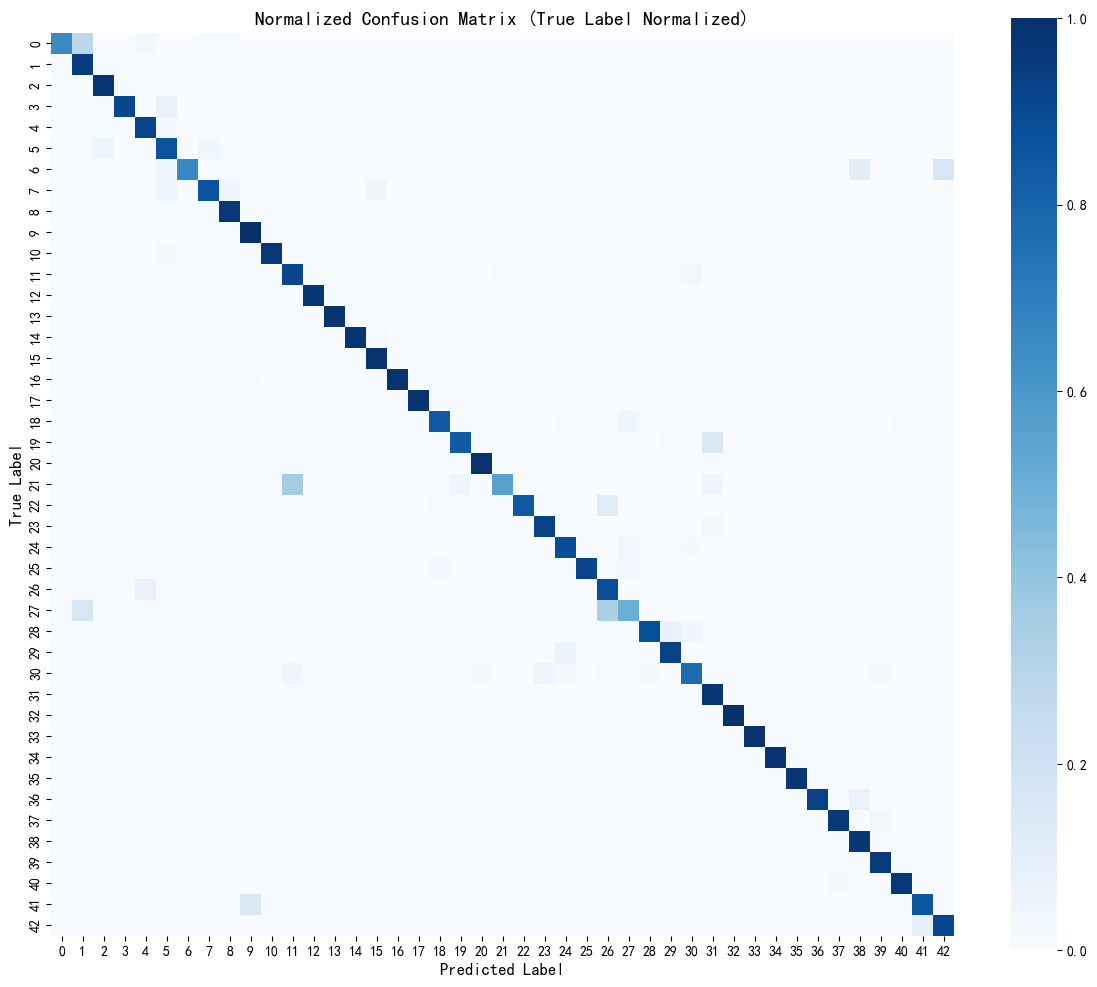

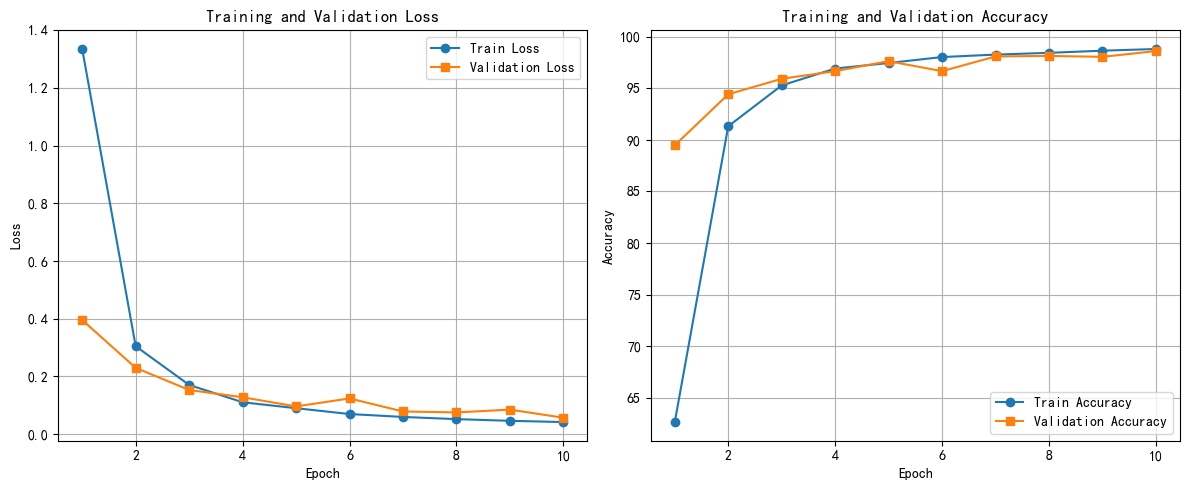

In [14]:
best_params = {'learning_rate': learning_rate, 'dropout_p': dropout_p}

# 加载最佳模型
model = GTSRBNet(43, best_params['dropout_p']).to(device)
model.load_state_dict(torch.load(GTSRBNet_save_path))
model.eval()

# 预测
predictions = []
with torch.no_grad():
    test_pbar = tqdm(test_loader, desc='测试集预测')
    for images, _ in test_pbar:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# 真值与预测
y_true = df_test['ClassId'].astype(int).tolist()
y_pred = [int(x) for x in predictions]

# 基本指标
acc = accuracy_score(y_true, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

print(f'Accuracy: {acc:.4f}')
print(f'Macro Precision: {prec_macro:.4f}  |  Macro Recall: {rec_macro:.4f}  |  Macro F1: {f1_macro:.4f}')
print(f'Weighted Precision: {prec_weighted:.4f}  |  Weighted Recall: {rec_weighted:.4f}  |  Weighted F1: {f1_weighted:.4f}')

# 混淆矩阵
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', annot=False, cbar=True, square=True)
plt.title('Normalized Confusion Matrix (True Label Normalized)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# 训练曲线：Loss 和 Accuracy
epochs = range(1, len(train_losses) + 1)

# Loss 曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 3.5 基线模型

### 3.5.1 定义模型 LeNet

In [15]:
# 参考LeNet的CNN模型
class LeNet(nn.Module):
    def __init__(self, num_classes=43):
        super(LeNet, self).__init__()
        # 第一层：卷积 + 池化
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2, 2)
        # 第二层：卷积 + 池化
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2, 2)
        # 全连接层
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 3.5.2 模型训练

In [16]:
model = LeNet(43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

num_epochs = 10
best_acc = 0

# 初始化记录列表
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # 训练
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc='训练中')
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # 更新进度条
        current_acc = 100 * train_correct / train_total
        train_pbar.set_postfix({
            'loss': f'{train_loss/(train_total//labels.size(0)):.4f}',
            'acc': f'{current_acc:.2f}%'
        })
    
    # 验证
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    val_pbar = tqdm(val_loader, desc='验证中')
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # 更新进度条
            current_acc = 100 * val_correct / val_total
            val_pbar.set_postfix({
                'loss': f'{val_loss/(val_total//labels.size(0)):.4f}',
                'acc': f'{current_acc:.2f}%'
            })

    # 计算平均指标
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    # 保存到列表
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'\n训练 Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.2f}%')
    print(f'验证 Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.2f}%')
    
    if val_acc > best_acc:
        best_acc = val_acc
        # torch.save(model.state_dict(), LeNet_save_path)
        print(f'✓ 保存最佳模型 (验证准确率: {val_acc:.2f}%)')

print(f'\n训练完成! 最佳验证准确率: {best_acc:.2f}%')


Epoch 1/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 36.98it/s, loss=0.2214, acc=87.52%]



训练 Loss: 1.2380, Acc: 63.58%
验证 Loss: 0.4139, Acc: 87.52%
✓ 保存最佳模型 (验证准确率: 87.52%)

Epoch 2/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 36.72it/s, loss=0.1299, acc=92.97%]



训练 Loss: 0.1974, Acc: 94.33%
验证 Loss: 0.2428, Acc: 92.97%
✓ 保存最佳模型 (验证准确率: 92.97%)

Epoch 3/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 38.09it/s, loss=0.0859, acc=95.75%]



训练 Loss: 0.1015, Acc: 97.24%
验证 Loss: 0.1607, Acc: 95.75%
✓ 保存最佳模型 (验证准确率: 95.75%)

Epoch 4/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.17it/s, loss=0.0670, acc=96.77%]



训练 Loss: 0.0798, Acc: 97.78%
验证 Loss: 0.1252, Acc: 96.77%
✓ 保存最佳模型 (验证准确率: 96.77%)

Epoch 5/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 43.12it/s, loss=0.0758, acc=96.23%]



训练 Loss: 0.0634, Acc: 98.22%
验证 Loss: 0.1417, Acc: 96.23%

Epoch 6/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.63it/s, loss=0.0560, acc=97.39%]



训练 Loss: 0.0570, Acc: 98.38%
验证 Loss: 0.1048, Acc: 97.39%
✓ 保存最佳模型 (验证准确率: 97.39%)

Epoch 7/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 35.93it/s, loss=0.0897, acc=95.54%]



训练 Loss: 0.0467, Acc: 98.64%
验证 Loss: 0.1678, Acc: 95.54%

Epoch 8/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 42.92it/s, loss=0.0477, acc=98.01%]



训练 Loss: 0.0386, Acc: 98.93%
验证 Loss: 0.0892, Acc: 98.01%
✓ 保存最佳模型 (验证准确率: 98.01%)

Epoch 9/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.87it/s, loss=0.0588, acc=97.40%]



训练 Loss: 0.0437, Acc: 98.76%
验证 Loss: 0.1100, Acc: 97.40%

Epoch 10/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 42.22it/s, loss=0.0697, acc=96.93%]


训练 Loss: 0.0434, Acc: 98.67%
验证 Loss: 0.1303, Acc: 96.93%

训练完成! 最佳验证准确率: 98.01%


### 3.5.3 测试集预测和评估

C:\Users\a1372\AppData\Local\Temp\ipykernel_23568\346459878.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(LeNet_save_path))
测试集预测: 100

Accuracy: 0.9238
Macro Precision: 0.8890  |  Macro Recall: 0.9031  |  Macro F1: 0.8927
Weighted Precision: 0.9273  |  Weighted Recall: 0.9238  |  Weighted F1: 0.9240


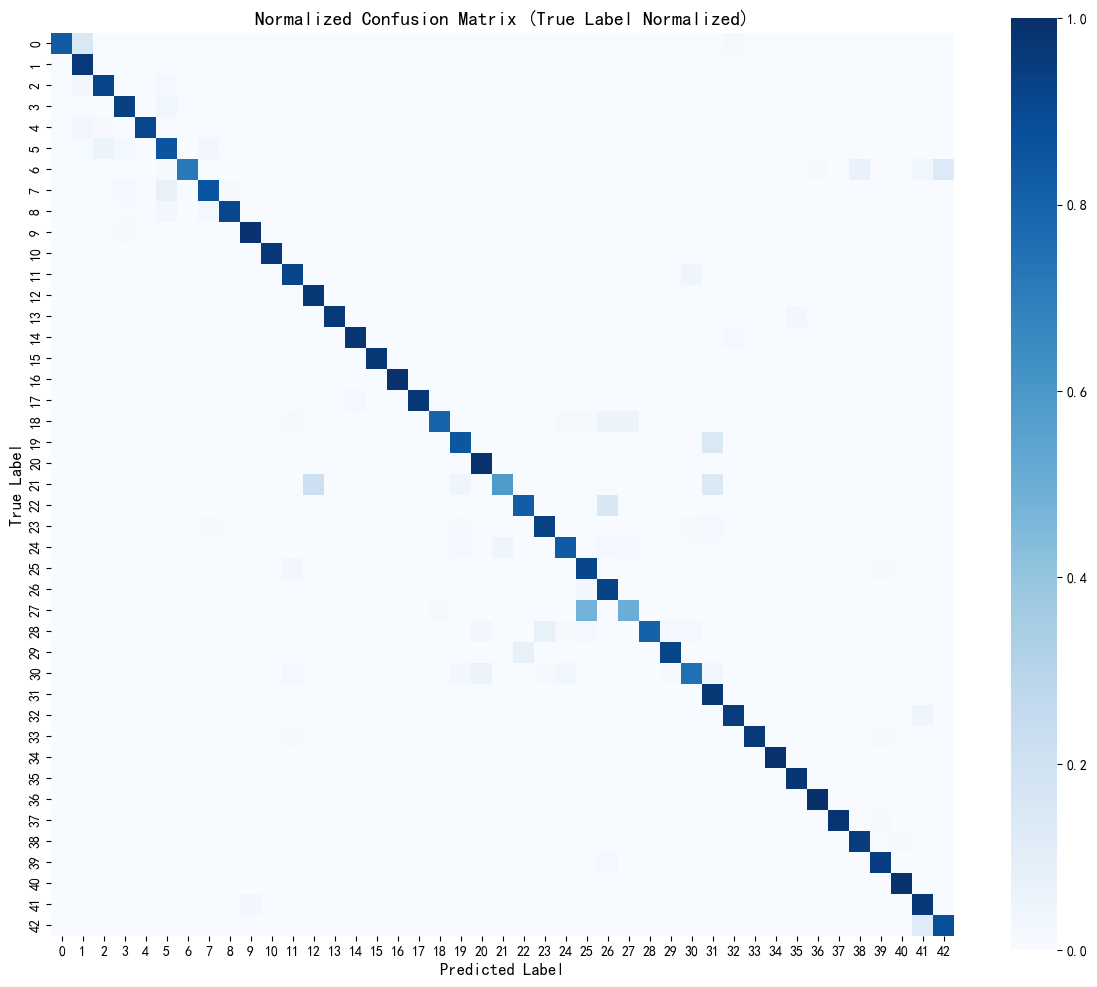

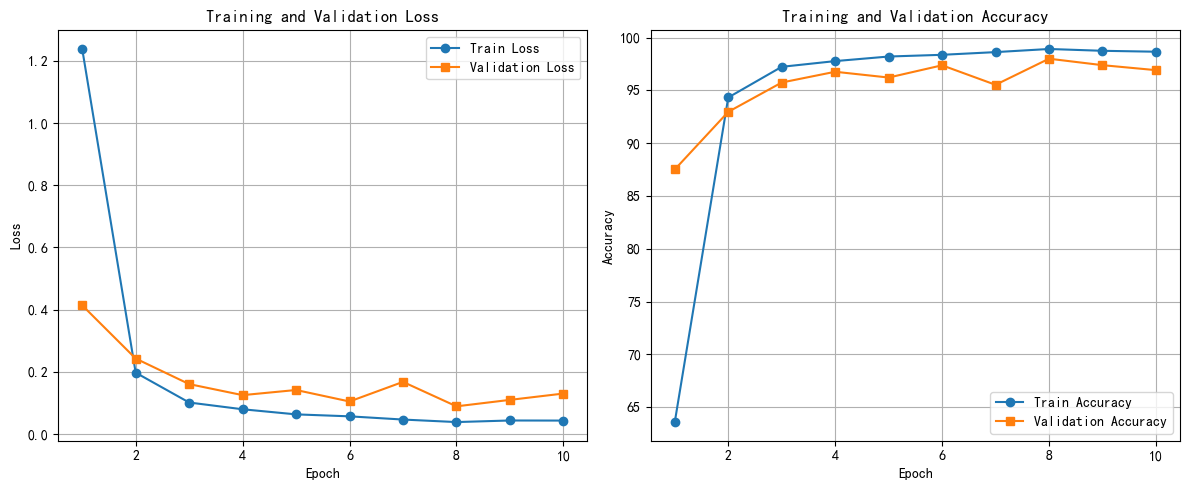

In [17]:
# 加载最佳模型
model = LeNet(43).to(device)
model.load_state_dict(torch.load(LeNet_save_path))
model.eval()

# 预测
predictions = []
with torch.no_grad():
    test_pbar = tqdm(test_loader, desc='测试集预测')
    for images, _ in test_pbar:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# 真值与预测
y_true = df_test['ClassId'].astype(int).tolist()
y_pred = [int(x) for x in predictions]

# 基本指标
acc = accuracy_score(y_true, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

print(f'Accuracy: {acc:.4f}')
print(f'Macro Precision: {prec_macro:.4f}  |  Macro Recall: {rec_macro:.4f}  |  Macro F1: {f1_macro:.4f}')
print(f'Weighted Precision: {prec_weighted:.4f}  |  Weighted Recall: {rec_weighted:.4f}  |  Weighted F1: {f1_weighted:.4f}')

# 混淆矩阵
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', annot=False, cbar=True, square=True)
plt.title('Normalized Confusion Matrix (True Label Normalized)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# 训练曲线：Loss 和 Accuracy
epochs = range(1, len(train_losses) + 1)

# Loss 曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 4 消融实验

In [ ]:
GTSRBNet_no_sampler_save_path = 'models/GTSRBNet_no_sampler.pth'
GTSRBNet_no_dropout_save_path = 'models/GTSRBNet_no_dropout.pth'

## 4.1 过采样消融

In [19]:
train_loader_no_sampler = DataLoader(train_data, batch_size=64, shuffle=True)

model = GTSRBNet(43, best_params['dropout_p']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

num_epochs = 10
best_acc = 0

# 初始化记录列表
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # 训练
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader_no_sampler, desc='训练中')
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # 更新进度条
        current_acc = 100 * train_correct / train_total
        train_pbar.set_postfix({
            'loss': f'{train_loss/(train_total//labels.size(0)):.4f}',
            'acc': f'{current_acc:.2f}%'
        })
    
    # 验证
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    val_pbar = tqdm(val_loader, desc='验证中')
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # 更新进度条
            current_acc = 100 * val_correct / val_total
            val_pbar.set_postfix({
                'loss': f'{val_loss/(val_total//labels.size(0)):.4f}',
                'acc': f'{current_acc:.2f}%'
            })

    # 计算平均指标
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    # 保存到列表
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'\n训练 Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.2f}%')
    print(f'验证 Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.2f}%')
    
    if val_acc > best_acc:
        best_acc = val_acc
        # torch.save(model.state_dict(), GTSRBNet_no_sampler_save_path)
        print(f'✓ 保存最佳模型 (验证准确率: {val_acc:.2f}%)')

print(f'\n训练完成! 最佳验证准确率: {best_acc:.2f}%')


Epoch 1/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 36.93it/s, loss=0.2023, acc=90.13%]



训练 Loss: 1.5148, Acc: 56.01%
验证 Loss: 0.3783, Acc: 90.13%
✓ 保存最佳模型 (验证准确率: 90.13%)

Epoch 2/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 38.33it/s, loss=0.1060, acc=94.63%]



训练 Loss: 0.5072, Acc: 83.95%
验证 Loss: 0.1982, Acc: 94.63%
✓ 保存最佳模型 (验证准确率: 94.63%)

Epoch 3/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 34.12it/s, loss=0.0764, acc=96.16%]



训练 Loss: 0.3421, Acc: 89.30%
验证 Loss: 0.1429, Acc: 96.16%
✓ 保存最佳模型 (验证准确率: 96.16%)

Epoch 4/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.45it/s, loss=0.0557, acc=97.55%]



训练 Loss: 0.2621, Acc: 91.85%
验证 Loss: 0.1041, Acc: 97.55%
✓ 保存最佳模型 (验证准确率: 97.55%)

Epoch 5/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 37.71it/s, loss=0.0477, acc=97.69%]



训练 Loss: 0.2253, Acc: 92.88%
验证 Loss: 0.0893, Acc: 97.69%
✓ 保存最佳模型 (验证准确率: 97.69%)

Epoch 6/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 34.75it/s, loss=0.0407, acc=98.02%]



训练 Loss: 0.2032, Acc: 93.52%
验证 Loss: 0.0761, Acc: 98.02%
✓ 保存最佳模型 (验证准确率: 98.02%)

Epoch 7/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 36.02it/s, loss=0.0361, acc=98.28%]



训练 Loss: 0.1776, Acc: 94.59%
验证 Loss: 0.0675, Acc: 98.28%
✓ 保存最佳模型 (验证准确率: 98.28%)

Epoch 8/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 37.36it/s, loss=0.0351, acc=98.47%]



训练 Loss: 0.1758, Acc: 94.49%
验证 Loss: 0.0656, Acc: 98.47%
✓ 保存最佳模型 (验证准确率: 98.47%)

Epoch 9/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:07<00:00, 15.52it/s, loss=0.0390, acc=98.20%]



训练 Loss: 0.1506, Acc: 95.25%
验证 Loss: 0.0730, Acc: 98.20%

Epoch 10/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:09<00:00, 13.46it/s, loss=0.0339, acc=98.37%]


训练 Loss: 0.1400, Acc: 95.58%
验证 Loss: 0.0634, Acc: 98.37%

训练完成! 最佳验证准确率: 98.47%


In [20]:
model = GTSRBNet(43, best_params['dropout_p']).to(device)
model.load_state_dict(torch.load(GTSRBNet_no_sampler_save_path))
model.eval()

# 预测
predictions = []
with torch.no_grad():
    test_pbar = tqdm(test_loader, desc='测试集预测')
    for images, _ in test_pbar:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# 真值与预测
y_true = df_test['ClassId'].astype(int).tolist()
y_pred = [int(x) for x in predictions]

# 基本指标
acc = accuracy_score(y_true, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

print(f'Accuracy: {acc:.4f}')
print(f'Macro Precision: {prec_macro:.4f}  |  Macro Recall: {rec_macro:.4f}  |  Macro F1: {f1_macro:.4f}')
print(f'Weighted Precision: {prec_weighted:.4f}  |  Weighted Recall: {rec_weighted:.4f}  |  Weighted F1: {f1_weighted:.4f}')

C:\Users\a1372\AppData\Local\Temp\ipykernel_23568\3666968720.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(GTSRBNet_no_sampler_save_pa

Accuracy: 0.9412
Macro Precision: 0.9296  |  Macro Recall: 0.9123  |  Macro F1: 0.9155
Weighted Precision: 0.9433  |  Weighted Recall: 0.9412  |  Weighted F1: 0.9402


## 4.2 Dropout 消融

In [21]:
model = GTSRBNet(43, 0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

num_epochs = 10
best_acc = 0

# 初始化记录列表
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # 训练
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc='训练中')
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # 更新进度条
        current_acc = 100 * train_correct / train_total
        train_pbar.set_postfix({
            'loss': f'{train_loss/(train_total//labels.size(0)):.4f}',
            'acc': f'{current_acc:.2f}%'
        })
    
    # 验证
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    val_pbar = tqdm(val_loader, desc='验证中')
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # 更新进度条
            current_acc = 100 * val_correct / val_total
            val_pbar.set_postfix({
                'loss': f'{val_loss/(val_total//labels.size(0)):.4f}',
                'acc': f'{current_acc:.2f}%'
            })

    # 计算平均指标
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    # 保存到列表
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'\n训练 Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.2f}%')
    print(f'验证 Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.2f}%')
    
    if val_acc > best_acc:
        best_acc = val_acc
        # torch.save(model.state_dict(), GTSRBNet_no_dropout_save_path)
        print(f'✓ 保存最佳模型 (验证准确率: {val_acc:.2f}%)')

print(f'\n训练完成! 最佳验证准确率: {best_acc:.2f}%')


Epoch 1/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:05<00:00, 21.34it/s, loss=0.1645, acc=91.46%]



训练 Loss: 0.8349, Acc: 76.82%
验证 Loss: 0.3076, Acc: 91.46%
✓ 保存最佳模型 (验证准确率: 91.46%)

Epoch 2/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 34.03it/s, loss=0.0974, acc=95.45%]



训练 Loss: 0.1344, Acc: 96.70%
验证 Loss: 0.1822, Acc: 95.45%
✓ 保存最佳模型 (验证准确率: 95.45%)

Epoch 3/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 38.83it/s, loss=0.0629, acc=97.08%]



训练 Loss: 0.0753, Acc: 98.00%
验证 Loss: 0.1177, Acc: 97.08%
✓ 保存最佳模型 (验证准确率: 97.08%)

Epoch 4/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:08<00:00, 14.17it/s, loss=0.0803, acc=95.79%]



训练 Loss: 0.0552, Acc: 98.41%
验证 Loss: 0.1501, Acc: 95.79%

Epoch 5/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.64it/s, loss=0.0670, acc=96.82%]



训练 Loss: 0.0447, Acc: 98.83%
验证 Loss: 0.1253, Acc: 96.82%

Epoch 6/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 35.65it/s, loss=0.0493, acc=97.58%]



训练 Loss: 0.0472, Acc: 98.63%
验证 Loss: 0.0922, Acc: 97.58%
✓ 保存最佳模型 (验证准确率: 97.58%)

Epoch 7/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 38.18it/s, loss=0.0461, acc=98.21%]



训练 Loss: 0.0394, Acc: 98.91%
验证 Loss: 0.0862, Acc: 98.21%
✓ 保存最佳模型 (验证准确率: 98.21%)

Epoch 8/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 43.04it/s, loss=0.0538, acc=97.62%]



训练 Loss: 0.0274, Acc: 99.18%
验证 Loss: 0.1007, Acc: 97.62%

Epoch 9/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:03<00:00, 39.80it/s, loss=0.0537, acc=97.90%]



训练 Loss: 0.0310, Acc: 99.10%
验证 Loss: 0.1005, Acc: 97.90%

Epoch 10/10
--------------------------------------------------


验证中: 100%|██████████| 123/123 [00:02<00:00, 41.37it/s, loss=0.0608, acc=97.21%]


训练 Loss: 0.0243, Acc: 99.31%
验证 Loss: 0.1136, Acc: 97.21%

训练完成! 最佳验证准确率: 98.21%


In [22]:
model = GTSRBNet(43, 0).to(device)
model.load_state_dict(torch.load(GTSRBNet_no_dropout_save_path))
model.eval()

# 预测
predictions = []
with torch.no_grad():
    test_pbar = tqdm(test_loader, desc='测试集预测')
    for images, _ in test_pbar:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# 真值与预测
y_true = df_test['ClassId'].astype(int).tolist()
y_pred = [int(x) for x in predictions]

# 基本指标
acc = accuracy_score(y_true, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

print(f'Accuracy: {acc:.4f}')
print(f'Macro Precision: {prec_macro:.4f}  |  Macro Recall: {rec_macro:.4f}  |  Macro F1: {f1_macro:.4f}')
print(f'Weighted Precision: {prec_weighted:.4f}  |  Weighted Recall: {rec_weighted:.4f}  |  Weighted F1: {f1_weighted:.4f}')

C:\Users\a1372\AppData\Local\Temp\ipykernel_23568\1114170096.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(GTSRBNet_no_dropout_save_pa

Accuracy: 0.9221
Macro Precision: 0.8999  |  Macro Recall: 0.8911  |  Macro F1: 0.8913
Weighted Precision: 0.9259  |  Weighted Recall: 0.9221  |  Weighted F1: 0.9215
